# Lineage: cell lineage and transition TF predictions

### Introduction

The ability to drive conversion between different cell states has
  garnered a great deal of attention as a promising avenue for disease
  modeling. A fundamental challenge in the field
  of stem cell biology is to identify and assess the feasibility of
  optimal paths and key TFs (transcription factors) of such
  interconversions (Figure 6A of :cite:p:`QIU2022`). The least action path (LAP) is a principled method that has previously been used in
  theoretical efforts to predict the most probable path a cell will
  follow during fate transition. Specifically, the optimal path between any two cell states
  (e.g. the fixed point of HSCs and that of megakaryocytes) is searched
  by variating the continuous path connecting the source state to the
  target while minimizing its action and updating the associated
  transition time. The resultant least action path has the highest
  transition probability and is associated with a particular transition
  time. Once the LAP is identified, we can focus only on TFs and rank them by the path integral of the mean square displacement (MSD) of gene expression with respect to the initial expression to identify key transcription factors of the associated cell fate transitions.

In this tutorial, we will demonstrate how to 
- perform LAP analyses;
- visualize transition paths found by the LAP approach on the vector field;
- plot heatmaps of actions and transition times matrix between all hematopoietic cell types;
- prioritize transcription factors of each predicted optimal path;
- ROC analyses of the LAP predictions.

Import relevant packages

In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn
import seaborn as sns


In [2]:
#dyn.dynamo_logger.main_silence()
dyn.configuration.set_figure_params('dynamo', background='white')
dyn.pl.style()



 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



Let us first load the human hematopoiesis scNT-seq dataset, which has stored as a sample dataset within dynamo that can be download directly using the above function, produced in this study (:cite:p:`QIU2022`). In this tutorial we will focus on analyzing this scNT-seq dataset because decades of researches in hematopoiesis make it a well suited system for testing LAP predictions. 


In [3]:
adata_labeling = dyn.sample_data.hematopoiesis()

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


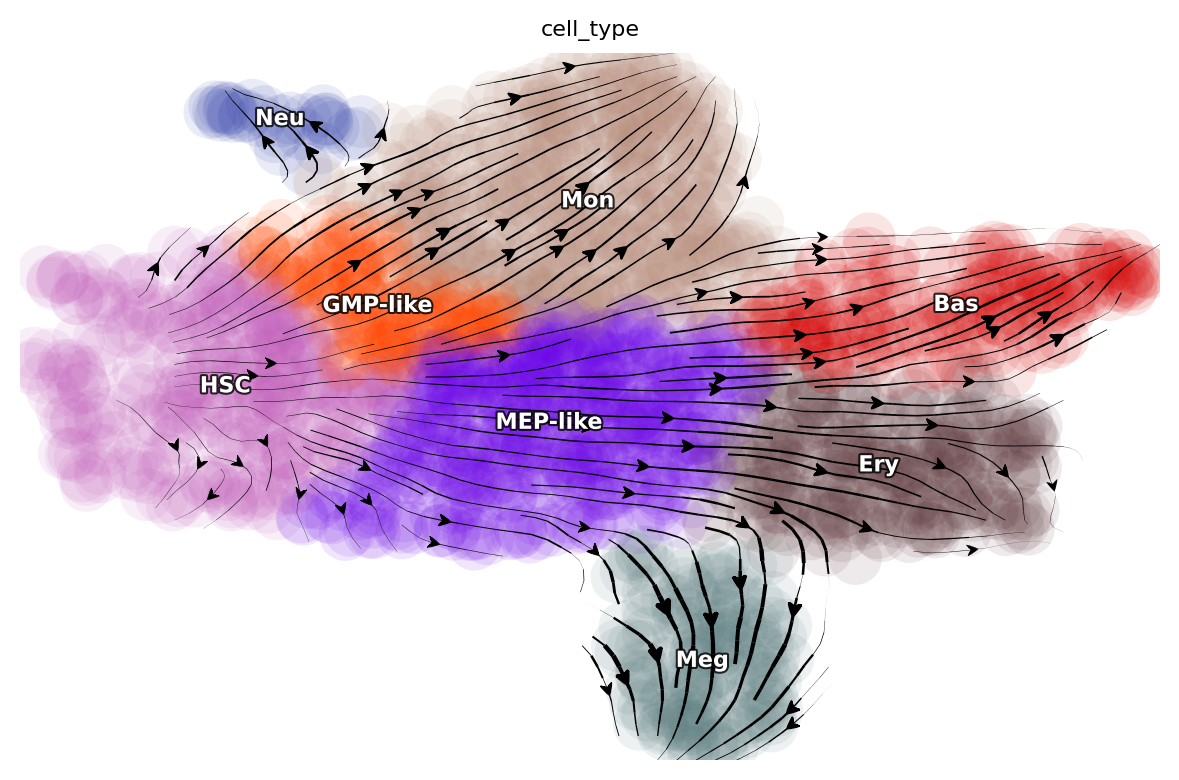

In [4]:
dyn.pl.streamline_plot(adata_labeling, basis="umap", color="cell_type")

HSC_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "HSC")
Meg_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Meg")
Ery_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Ery")
Bas_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Bas")
Mon_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Mon")
Neu_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Neu")

### Compute neighbor graph based on `umap`

In [8]:
dyn.tl.neighbors(adata_labeling, basis="umap", result_prefix="umap")


|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> umap_connectivities to obsp in AnnData Object.
|-----> <insert> umap_distances to obsp in AnnData Object.
|-----> <insert> umap_neighbors to uns in AnnData Object.
|-----> <insert> umap_neighbors.indices to uns in AnnData Object.
|-----> <insert> umap_neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

### Run pairwise least action path analyses among six distinct hematopoietic cell types

This section will demonstrate how to compute LAPs for all possible cell type transition pairs in our scNT-seq dataset. The corresponding function in
*dynamo* is ``dyn.pd.least_action``. This function takes an ``adata`` object that has continous vector field reconstructed, a start
cell and a target cell to compute least action path or most probable path between them. As shown
above, either UMAP or PCA basis can be used. Here we use the UMAP basis to visualize the LAP and the PCA basis 
for downstream transcription factor prioritization and other analyses.

Note that the following block also demonstrates using the `GeneTrajectory` function to reverse project the optimized LAP in PCA space back to the original gene expression space to reveal the transcriptomic kinetics along the LAP. We then calculate the accumulative MSD (mean square displacement) with respect to the initial state of each gene along the LAP in the original gene expression space (with `calc_msd` function) and use this score to prioritize the importance of each gene (with `rank_genes` function). Genes with top MSD have higher variances with respect to the initial state and will be ranked higher, which may also indicate key roles in making the cell fate conversions. 

Please refer to the API documentation of each of these functions for
detailed explanation of their input parameters, output, etc. Please also check our primers on the optimal path and the Cell paper for more in-depth understandings. 

We select the five closest cells of the identified attractors that correspond to each of the six cell types to represent the typical cell state of these cells (note that attractors often don't correspond to any particular cell).

In the version of dynamo 1.4.2, we can calculate the closest cells of the identified attractors automatically.

In [ ]:
cell_types = ["HSC", "Meg", "Ery", "Bas", "Mon", "Neu"]

transition_graph, cells_indices = dyn.pd.compute_cell_type_transitions(
    adata=adata_labeling,  # Your AnnData object
    cell_types=cell_types,
    reference_cell_types=["HSC"],  # HSC as reference cell type
    marginal_method='combined',
    potential_column='umap_ddhodge_potential',
    cell_type_column='cell_type',
    EM_steps=2,
    top_genes=5,
    enable_plotting=True,
    enable_gene_analysis=True
)

# Access results
print("Available transition paths:")
for transition_name in transition_graph.keys():
    print(f"  {transition_name}")

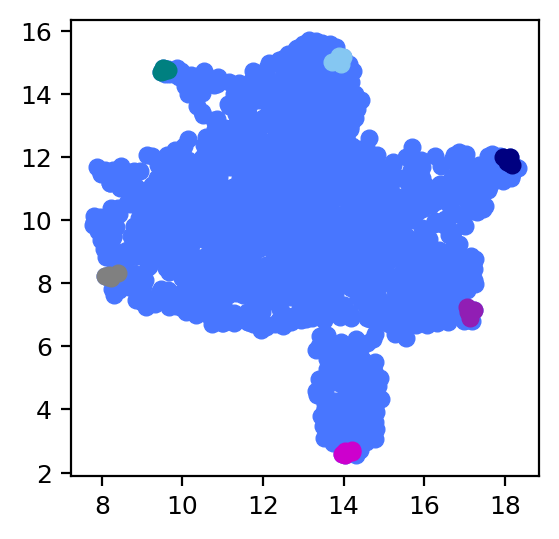

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.scatter(*adata_labeling.obsm["X_umap"].T)
for indices in cells_indices.values():
    #print(indices)
    plt.scatter(*adata_labeling[indices[0]].obsm["X_umap"].T)
plt.show()

Since the above calculation process is slow, we provide two functions to store the results so that repeated calculations can be avoided.

In [108]:
adata_labeling.write('result/adata_labeling_analysis.h5ad')

In [3]:
#adata_labeling=dyn.read('result/adata_labeling_analysis.h5ad')

In [34]:
dyn.utils.save_pickle(transition_graph,'result/transition_graph.pkl')
dyn.utils.save_pickle(cells_indices,'result/cells_indices.pkl')

In [35]:
transition_graph=dyn.utils.load_pickle('result/transition_graph.pkl')
cells_indices=dyn.utils.load_pickle('result/cells_indices.pkl')

## Visualize developmental LAPs

In [5]:
develope_keys = ["HSC->Meg", "HSC->Ery", "HSC->Bas", "HSC->Mon", "HSC->Neu"]
reprogram_keys = ["Meg->HSC", "Ery->HSC", "Bas->HSC", "Mon->HSC", "Neu->HSC"]
transdifferentiation = [
    "Ery->Meg",
    "Neu->Bas",
    "Mon->Ery",
    "Bas->Meg",
    "Neu->Meg",
    "Meg->Bas",
    "Mon->Bas",
    "Neu->Mon",
    "Meg->Ery",
    "Ery->Bas",
    "Bas->Mon",
    "Mon->Neu",
    "Neu->Ery",
    "Mon->Meg",
    "Bas->Neu",
    "Meg->Neu",
    "Ery->Mon",
    "Meg->Mon",
    "Ery->Neu",
    "Bas->Ery",
]

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


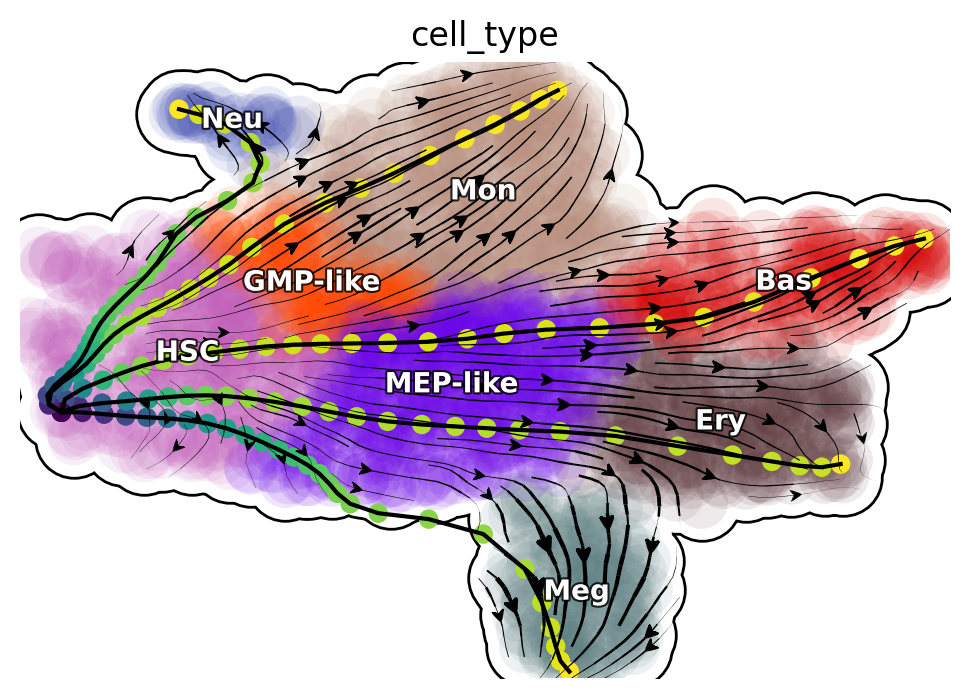

In [8]:
%matplotlib inline
from dynamo.plot.utils import map2color
def plot_lap(paths):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = dyn.pl.streamline_plot(
        adata_labeling, basis="umap", save_show_or_return="return", ax=ax, color="cell_type", frontier=True
    )
    ax = ax[0]
    x, y = 0, 1

    # plot paths
    for path in paths:
        lap_dict = transition_graph[path]["LAP_umap"]
        for prediction, action in zip(lap_dict["prediction"], lap_dict["action"]):
            ax.scatter(*prediction[:, [x, y]].T, c=map2color(action))
            ax.plot(*prediction[:, [x, y]].T, c="k")
plot_lap(develope_keys)

**Reprogram LAPs**

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


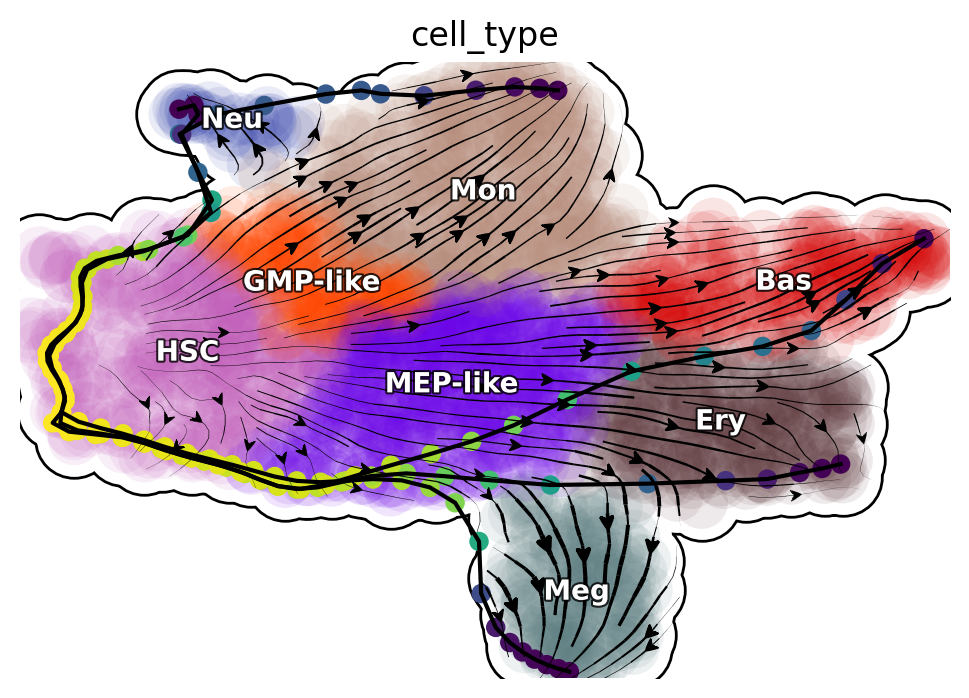

In [7]:
%matplotlib inline
plot_lap(reprogram_keys)

**Transdifferentiation LAPs**

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


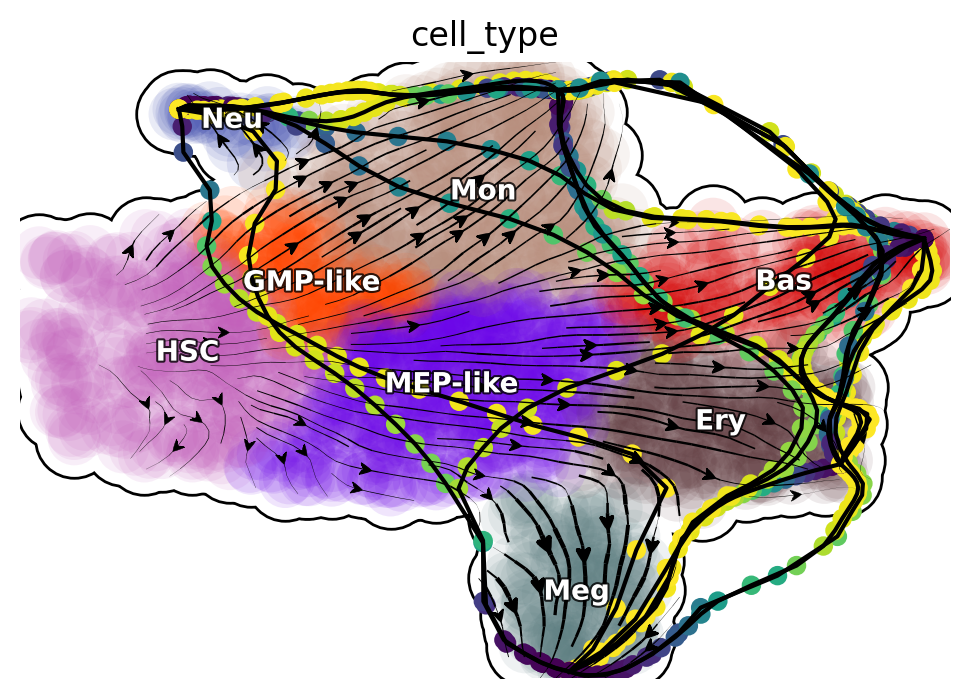

In [9]:
%matplotlib inline
plot_lap(transdifferentiation)

Next, we will focus on transcription factors (TFs) and rank them based on their MSD along the LAP path to prioritize the importance of each TF. Meanwhile, we will also keep the action (an functional of the LAP) and the least action path time, with `action_df` and `t_df`, respectively, of each of these conversions. 

In [10]:
human_tfs = dyn.sample_data.human_tfs()
human_tfs_names = list(human_tfs["Symbol"])

In [11]:
cell_types = ["HSC", "Meg", "Ery", "Bas", "Mon", "Neu"]

# Simple version (exactly like your original code)
action_df, t_df, tf_genes = dyn.pd.extract_transition_metrics(
    transition_graph=transition_graph,
    cells_indices_dict=cells_indices,
    cell_types=cell_types,
    transcription_factors=human_tfs_names,
    top_tf_genes=10,
    lap_method='action_t',
)


HSC->Meg,HSC->Ery,HSC->Bas,HSC->Mon,HSC->Neu,Meg->HSC,Meg->Ery,Meg->Bas,Meg->Mon,Meg->Neu,Ery->HSC,Ery->Meg,Ery->Bas,Ery->Mon,Ery->Neu,Bas->HSC,Bas->Meg,Bas->Ery,Bas->Mon,Bas->Neu,Mon->HSC,Mon->Meg,Mon->Ery,Mon->Bas,Mon->Neu,Neu->HSC,Neu->Meg,Neu->Ery,Neu->Bas,Neu->Mon,
Extraction completed!


We now visualize the LAP time of all developmental LAPs. Interestingly, we show that the LAP time from HSC to Meg lineage LAP (28 hour) is the shortest among all
developmental LAPs, consistent with the fact that megakaryocyte is the earliest cell type to appear. The predicted 28 hours is also on the time-scale of what has been reported for the single HSC transplantation experiments. We want to note that because we used the metabolic labeling based scRNA-seq, we obtained absolute RNA velocity and thus we can predict the actual time (with units of hour) of the LAP, a rather remarkable feature of the labeling data. 

    integration time lineage
HSC              NaN     HSC
Meg        38.552163     Meg
Ery         51.82503     Ery
Bas        62.582264     Bas
Mon        37.262829     Mon
Neu        64.133078     Neu


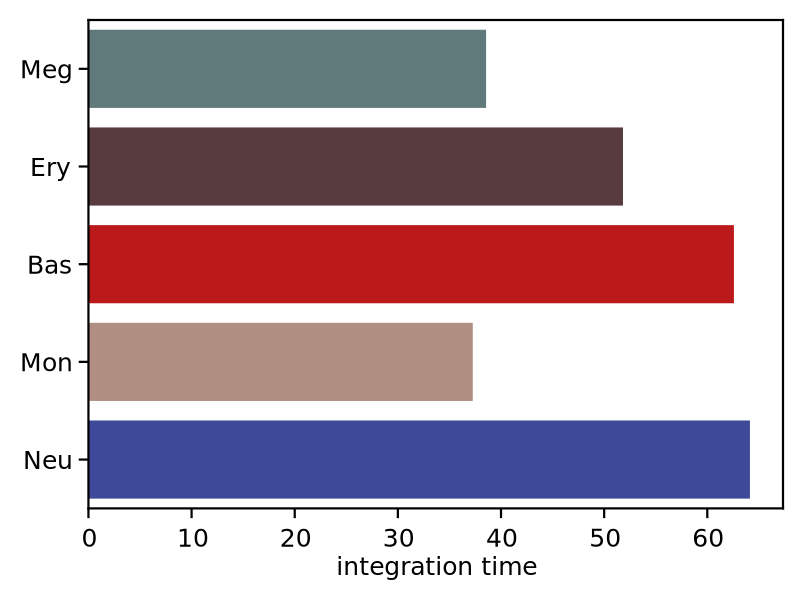

In [12]:
%matplotlib inline
import seaborn as sns
dyn.configuration.set_pub_style(scaler=1.5)
develop_time_df = pd.DataFrame({"integration time": t_df.iloc[0, :].T})
develop_time_df["lineage"] = ["HSC", "Meg", "Ery", "Bas", "Mon", "Neu"]
print(develop_time_df)
fig, ax = plt.subplots(figsize=(4, 3))
dynamo_color_dict = {
    "Mon": "#b88c7a",
    "Meg": "#5b7d80",
    "MEP-like": "#6c05e8",
    "Ery": "#5d373b",
    "Bas": "#d70000",
    "GMP-like": "#ff4600",
    "HSC": "#c35dbb",
    "Neu": "#2f3ea8",
}

sns.barplot(
    y="lineage",
    x="integration time",
    hue="lineage",
    data=develop_time_df.iloc[1:, :],
    dodge=False,
    palette=dynamo_color_dict,
    ax=ax,
)
ax.set_ylabel("")
plt.tight_layout()
fig
#plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [13]:
#dyn.configuration.set_pub_style(scaler=3)

## Heatmap of LAP actions and LAP time matrices of pairwise cell fate conversions


Here we are going to visualize the transition matrices of actions and LAP time between all pair-wise cell type conversions with heatmaps. Overall, we find the the developmental LAP time is much larger than that of the dedifferentiation LAP while the action has the opposite pattern. 

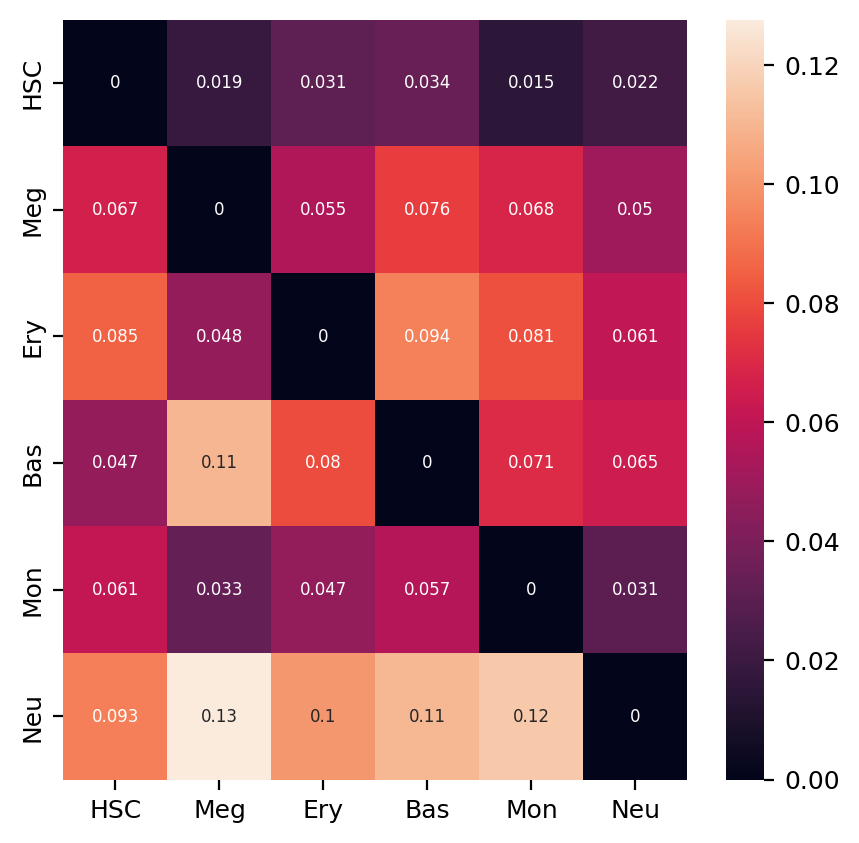

In [15]:
%matplotlib inline
action_df = action_df.fillna(0)
f, ax = plt.subplots(figsize=(5, 5))
#dyn.configuration.set_pub_style(scaler=3)
ax = sns.heatmap(action_df, annot=True, ax=ax, fmt=".2g")


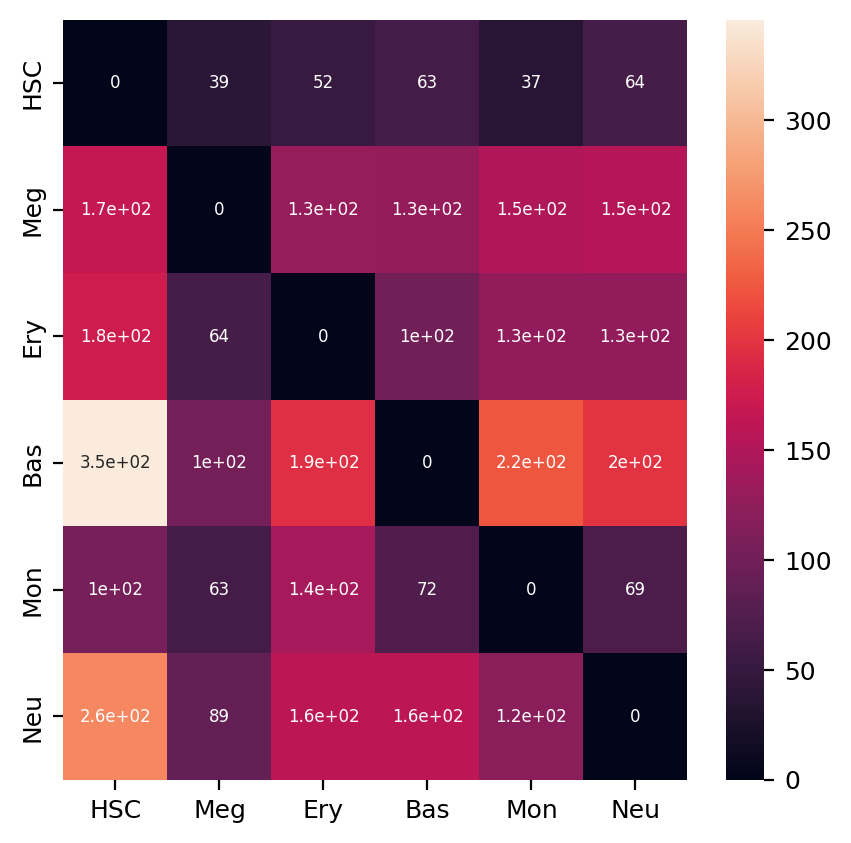

In [16]:
%matplotlib inline
action_df = action_df.fillna(0)
f, ax = plt.subplots(figsize=(5, 5))
#dyn.configuration.set_pub_style(scaler=3)
t_df = t_df.fillna(0)
ax = sns.heatmap(t_df, annot=True, ax=ax, fmt=".2g")


## Kinetics heatmap of gene expression dynamics along the LAP

As mentioned above, we are able to obtain the gene-wise kinetics when we reverse projected the LAP learned in PCA space back to gene-wise space. In this section we will show how to do so and we will create a kinetics heatmap of the transcriptomic dynamics along the LAP from HSC to basophil lineage. We will rely on mainly two functions, ``dyn.pd.least_action``  and ``dyn.pl.kinetic_heatmap``. ``dyn.pd.least_action`` can be used to computes the optimal paths between any two cell states, as mentioned above while ``dyn.pl.kinetic_heatmap`` can be used to plot kinetics
heatmap.

Here we will identify the LAP from the HSC to basophil lineage, and thus one typical HSC and one typical basophil cell are chosen as the initial and target cell, respectively. 

Transition: HSC → Bas
Initial cells: ['GGCAGCTCACTC-JL_10']
Target cells: ['GCAGCGAAGGCA-JL12_0']
Using 110 transcription factors for analysis

Computing least action path...
|-----> searching for the least action path...
|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.027293
|-----> [least action path] completed [5.6226s]
Generating kinetic heatmap...
Figure saved to: figures/fig5/HSC_to_Bas.png


<Figure size 1600x400 with 0 Axes>

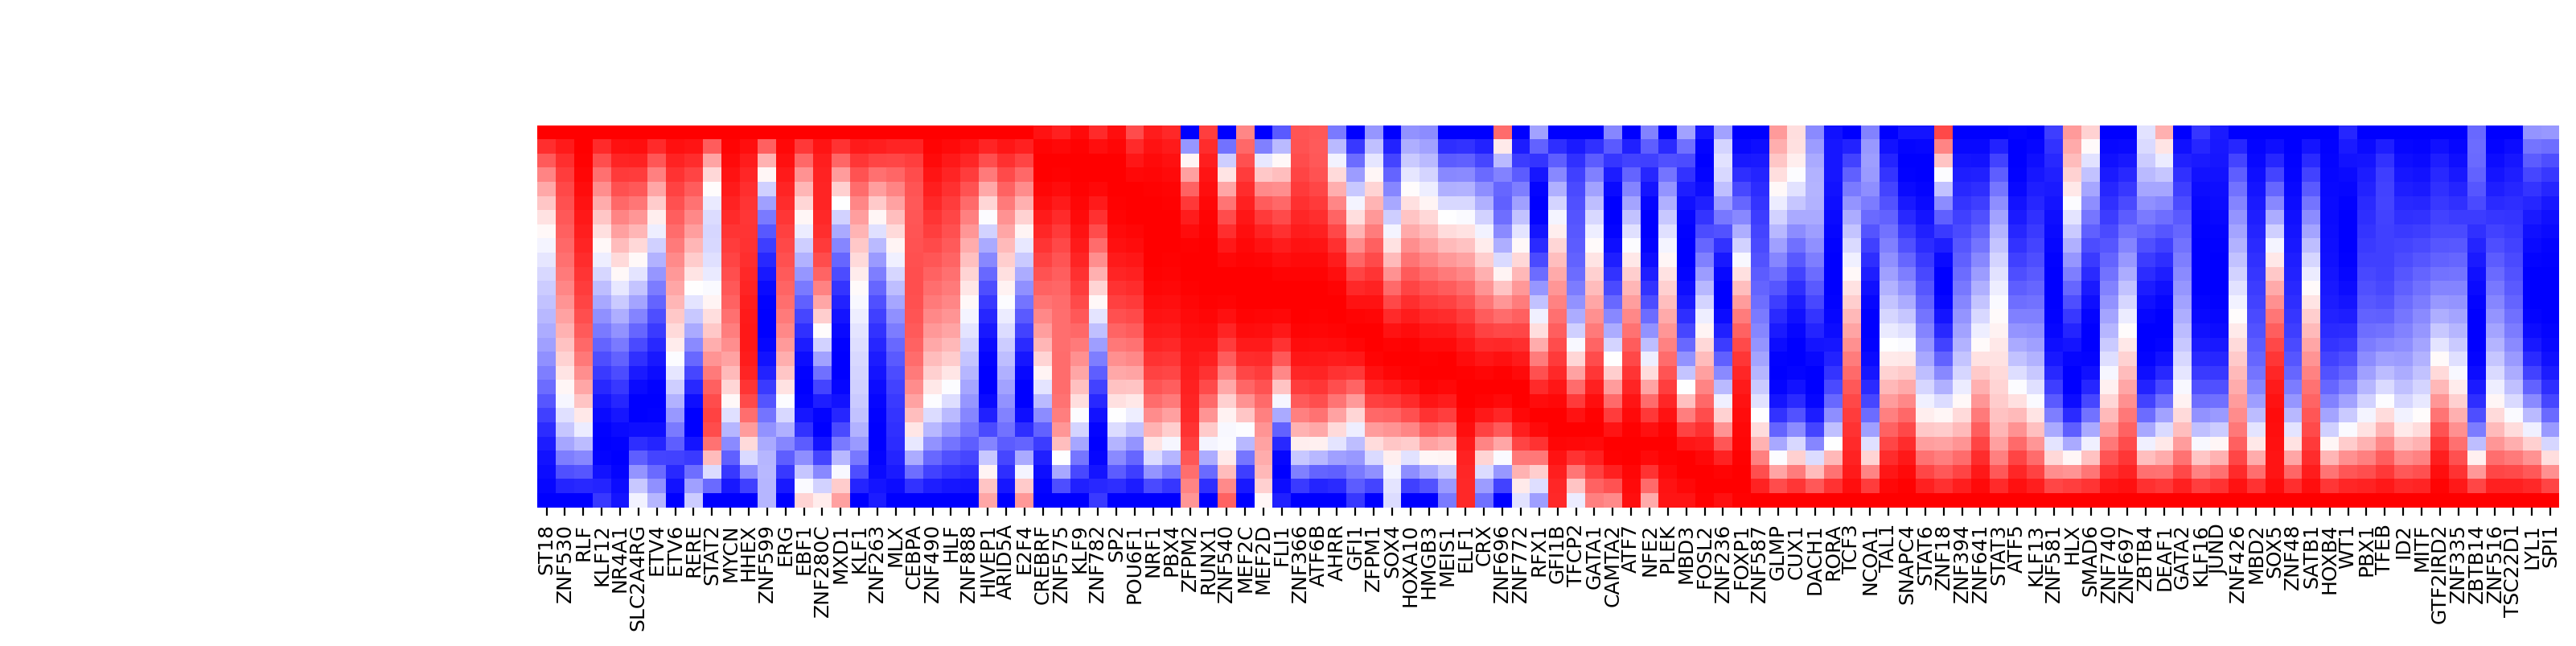

Completed kinetic heatmap for HSC → Bas


In [17]:
%matplotlib inline
# create positive heatmap：HSC → Basophil  
fig=dyn.pd.plot_kinetic_heatmap(
    adata=adata_labeling,
    cells_indices_dict=cells_indices,
    source_cell_type='HSC',
    target_cell_type='Bas',
    transcription_factors=human_tfs_names,
    save_path='figures/fig5/HSC_to_Bas.png',
    figsize=(16, 4),
)
#plt.show()

Transition: Bas → HSC
Initial cells: ['GCAGCGAAGGCA-JL12_0']
Target cells: ['GGCAGCTCACTC-JL_10']
Using 110 transcription factors for analysis

Computing least action path...
|-----> searching for the least action path...
|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.047440
|-----> [least action path] completed [11.5497s]
Generating kinetic heatmap...
Figure saved to: figures/fig5/Bas_to_HSC.png


<Figure size 1600x400 with 0 Axes>

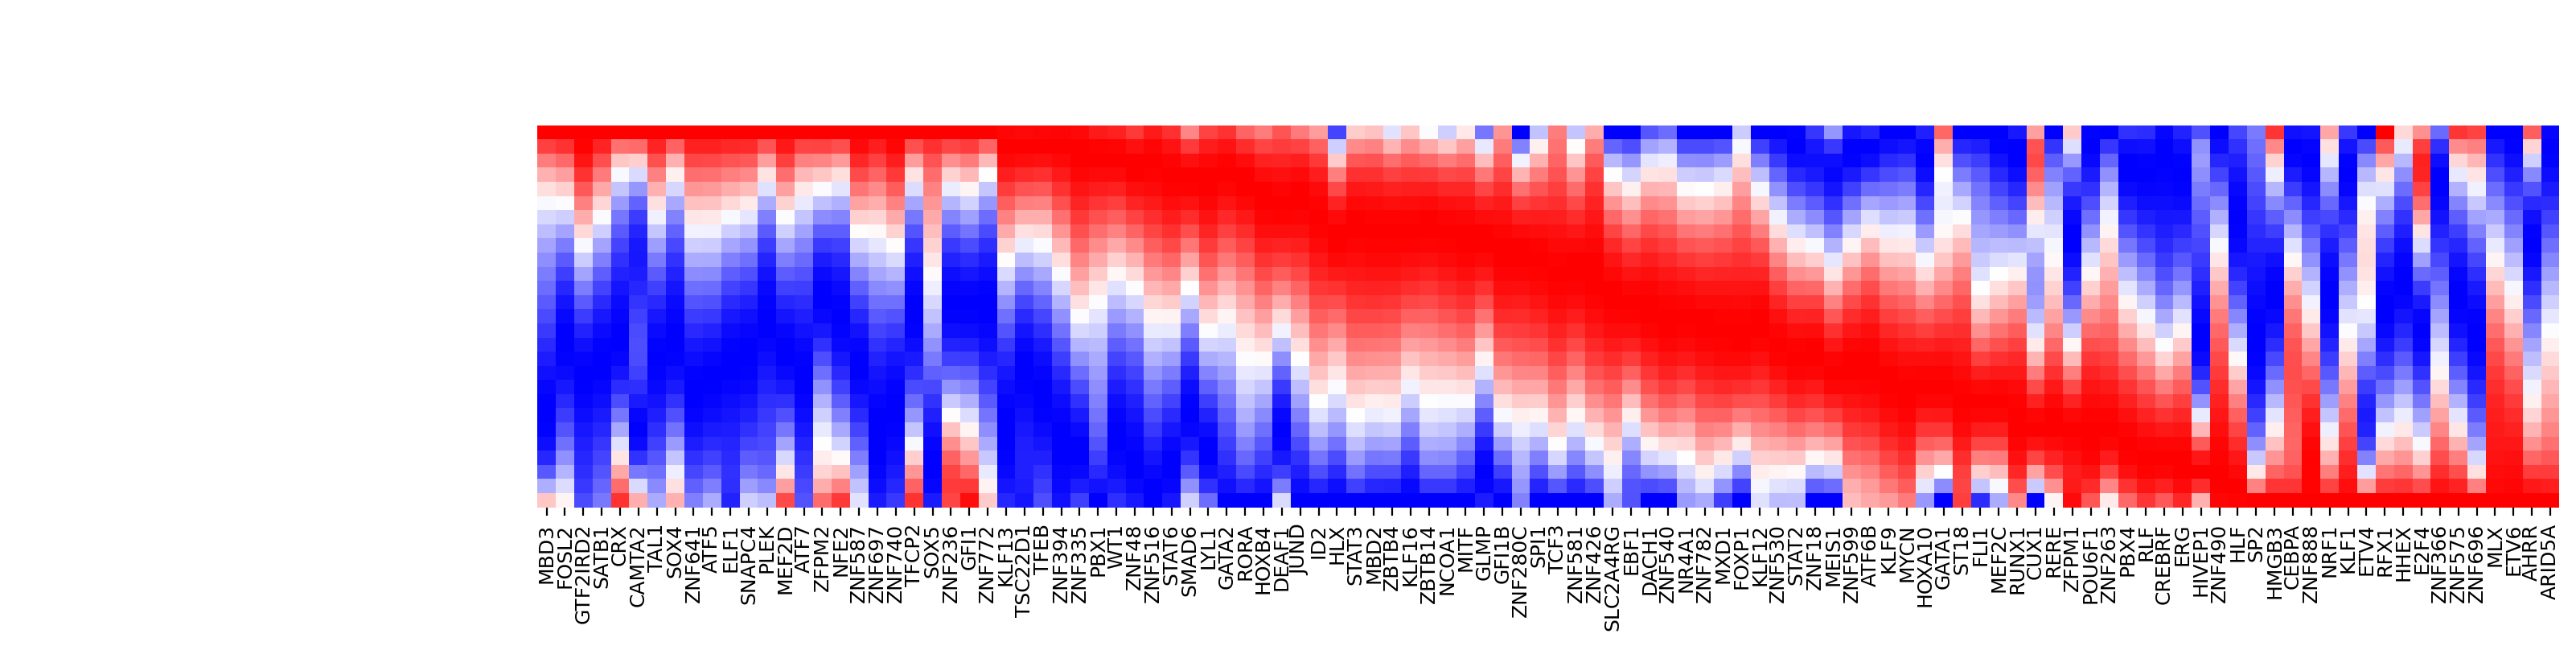

Completed kinetic heatmap for Bas → HSC


In [18]:
# create negative heatmap：Basophil → HSC
dyn.pd.plot_kinetic_heatmap(
    adata=adata_labeling,
    cells_indices_dict=cells_indices,
    source_cell_type='Bas',      
    target_cell_type='HSC',      
    transcription_factors=human_tfs_names,
    save_path='figures/fig5/Bas_to_HSC.png',
    figsize=(16, 4),
)

In [19]:
# analysis dynamic TF
ranking, top_tfs = dyn.pd.analyze_kinetic_genes(
    adata=adata_labeling,
    cells_indices_dict=cells_indices,
    source_cell_type='HSC',
    target_cell_type='Bas',
    transcription_factors=human_tfs_names,
    top_genes=15
)

Analyzing gene dynamics for HSC → Bas
|-----> searching for the least action path...
|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.027293
|-----> [least action path] completed [5.7632s]
Top 15 transcription factors:
  1. GATA2
  2. ELF1
  3. TAL1
  4. JUND
  5. PLEK
  6. ETV6
  7. HMGB3
  8. ZNF394
  9. SATB1
  10. TSC22D1
  11. FOXP1
  12. ZNF740
  13. MBD2
  14. GATA1
  15. RUNX1


/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/dynamo/prediction/trajectory.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.adata.var[save_key][self.genes_to_mask()] = msd


## Evaluate TF rankings based on LAP analyses
As mentioned above, we can rank TFs based on the mean square displacement (MSD) along the LAP . In this section, we are going to evaluate rankings from LAP analyses by comparing with known transcription factors that enable the successful cell fate conversion, reported from literature. More details can be found in the dynamo paper :cite:p:`QIU2022`. 

We first prepare TF ranking dataframes that will be used to create ranking statistics in this
section. We first identify the TFs from all genes (``["TF"]`` key) and tag TFs that are known transcription factor for the corresponding cell fate conversion  (``["known_TF"]`` key). To the best we can, we all manually compiled all known factors for all known hematopoietic cell fate transitions (including developmental process). Please see supplementary table 2 from dynamo paper :cite:p:`QIU2022` for more details. 

This part is specific to our scNT-seq dataset but should be easily changed to meet your needs as well. 

In [17]:
# Known transcription factors for each transition type
KNOWN_TFS_DICT = {
    "HSC->Meg": ["GATA1", "GATA2", "ZFPM1", "GFI1B", "FLI1", "NFE2"],
    "HSC->Ery": ["GATA1", "ZFPM1", "GFI1B", "KLF1", "SPI1", "GATA2", "LDB1", "TAL1", "ZFPM1"],
    "HSC->Bas": ["CEBPA", "GATA2", "GATA1", "RUNX1"],
    "HSC->Mon": ["SPI1", "IRF8", "IRF5", "ZEB2", "KLF4"],
    "HSC->Neu": ["GFI1", "PER3", "GATA1", "ETS3"],
    "Meg->HSC": ["RUN1T1", "HLF", "LMO2", "PRDM5", "PBX1", "ZFP37", "MYCN", "MEIS1"],
    "Ery->Mon": ["LSD1", "RUNX1"],
    "Ery->Neu": ["LSD1", "RUNX1"],  # First set
    "Ery->Neu_alt": ["CEBPA", "CEBPB", "CEBPE", "SPI1"],  # Alternative set
    "Mon->Bas": ["GATA2", "CEBPA"],
    "Neu->Bas": ["GATA2", "CEBPA"],
    "Mon->Meg": ["GATA1", "ZFPM1", "GATA2"],
    "Mon->Ery": ["GATA1", "ZFPM1", "GATA2"],
    "Meg->Neu": ["CEBPA", "CEBPB", "CEBPE", "SPI1"]
}

# PMID references for each transition
TRANSITION_PMIDS = {
    "HSC->Meg": 18295580, "HSC->Ery": 18295580, "HSC->Bas": 18295580,
    "HSC->Mon": 18295580, "HSC->Neu": 18295580, "Meg->HSC": 24766805,
    "Meg->Neu": 31395745, "Ery->Mon": 34324630, "Ery->Neu1": 31395745,
    "Ery->Neu2": 34324630, "Mon->Meg": 14499119, "Mon->Ery": 14499119,
    "Mon->Bas": 17079688, "Neu->Bas": 17079688
}

# Transition type classification
TRANSITION_TYPES = {
    "HSC->Meg": "development", "HSC->Ery": "development", "HSC->Bas": "development",
    "HSC->Mon": "development", "HSC->Neu": "development", "Meg->HSC": "reprogramming",
    "Meg->Neu": "transdifferentiation", "Ery->Mon": "transdifferentiation",
    "Ery->Neu1": "transdifferentiation", "Ery->Neu2": "transdifferentiation",
    "Mon->Meg": "transdifferentiation", "Mon->Ery": "transdifferentiation",
    "Mon->Bas": "transdifferentiation", "Neu->Bas": "transdifferentiation"
}


In [18]:
# Define transitions configuration (move outside functions for flexibility)
TRANSITIONS_CONFIG = {
    "standard": [
        "HSC->Meg", "HSC->Ery", "HSC->Bas", "HSC->Mon", "HSC->Neu",
        "Meg->HSC", "Meg->Neu", "Ery->Mon", "Mon->Meg", "Mon->Ery", 
        "Mon->Bas", "Neu->Bas"
    ],
    "special": {
        "Ery->Neu": {
            "sets": [
                ("TFs1", "TFs_rank1", "Ery->Neu1"), 
                ("TFs2", "TFs_rank2", "Ery->Neu2")
            ]
        }
        # Add more special cases here if needed
    }
}

# Custom color scheme (optional)
CUSTOM_COLORS = {
    "development": "#2E3192", 
    "reprogramming": "#EC2227", 
    "transdifferentiation": "#B9519E"
}

### Ranking TF's importance for each LAP

Let's re-rank each known TF from each known hematopoietic fate conversion based on their MSD rankings among all TFs. We will use the helper function
``assign_tf_ranks`` to achieve this purpose. All the known TFs are collected from literature as mentioned above.


Here we will convert the rankings of known TFs to a priority score, simply defined as $1 - \frac{\# rank}{\# TF}$.


Processing transition rankings...
Creating reprogramming matrix...
Plotting transdifferentiation transitions...


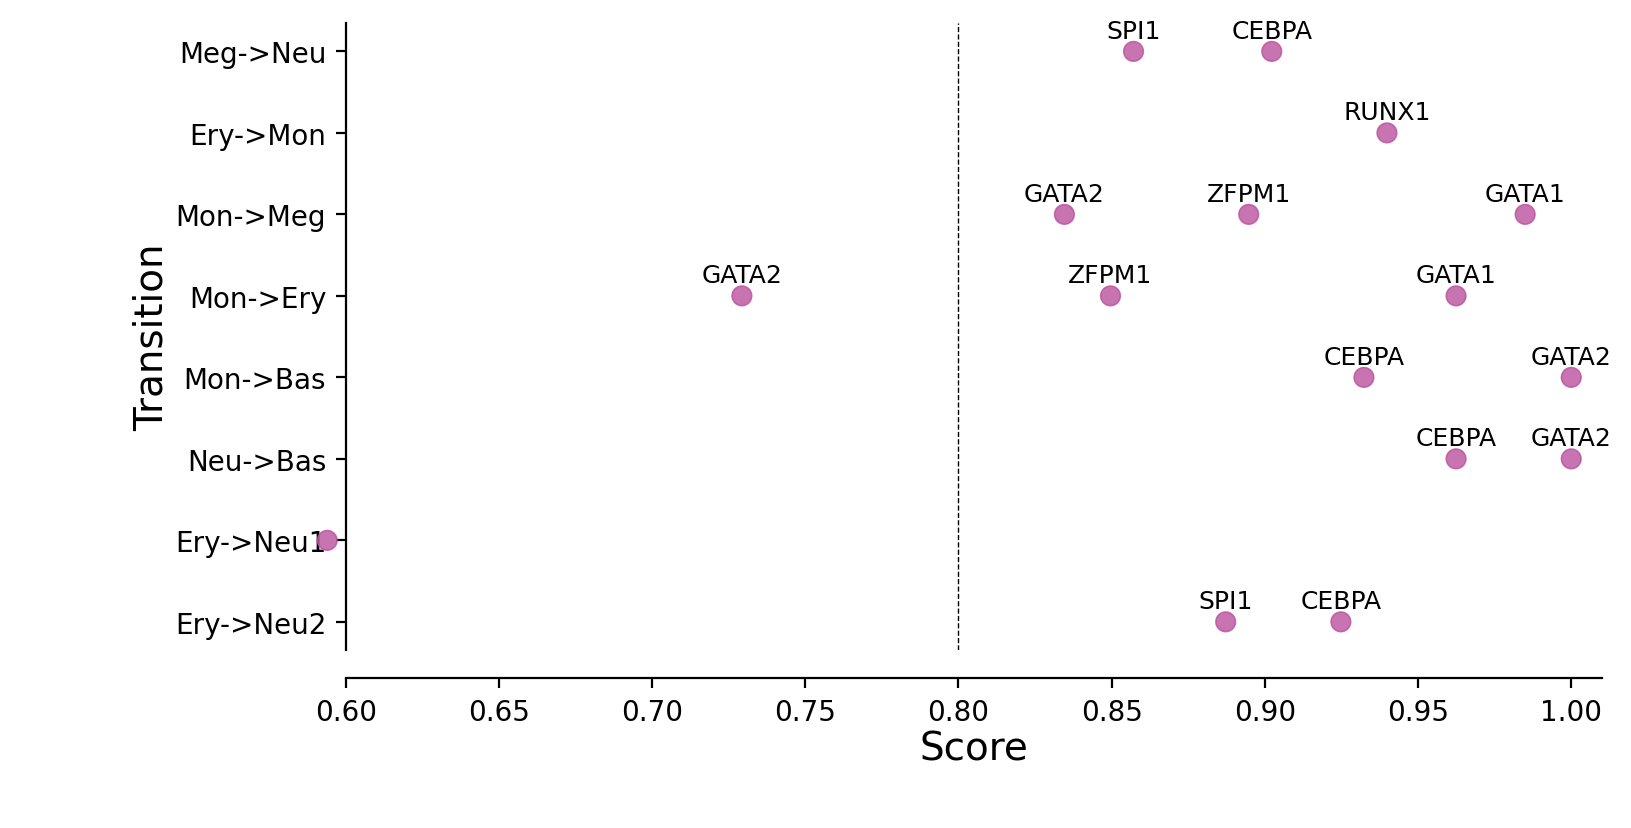

In [19]:
# Run complete analysis with custom configuration
processed_rankings, reprogramming_dict, reprogramming_df = dyn.pd.analyze_transition_tfs(
    transition_graph=transition_graph,
    human_tfs_names=human_tfs_names,
    transitions_config=TRANSITIONS_CONFIG,
    plot_type="transdifferentiation",
    total_tf_count=133,  # Adjust based on your TF count
    transition_color_dict=CUSTOM_COLORS,
    known_tfs_dict=KNOWN_TFS_DICT,
    transition_pmids=TRANSITION_PMIDS,
    transition_types=TRANSITION_TYPES,
    figsize=(8,4)
)


### Plotting priority scores of known TFs for specific hematopoietic trandifferentiations
The y-axis is the hematopoietic trandifferentiation and the x-axis the TF priority scores for a specific transition.


In [20]:
# Or use individual functions for more control

# Step 1: Process rankings
processed_rankings = dyn.pd.process_all_transition_rankings(
    transition_graph, human_tfs_names, KNOWN_TFS_DICT
)

In [21]:
# Step 2: Create matrix with custom config
reprogramming_dict, reprogramming_df = dyn.pd.create_reprogramming_matrix(
    transition_graph=transition_graph,
    transitions_config=TRANSITIONS_CONFIG,
    transition_pmids=TRANSITION_PMIDS,
    transition_types=TRANSITION_TYPES,
    total_tf_count=133  # Your actual TF count
)

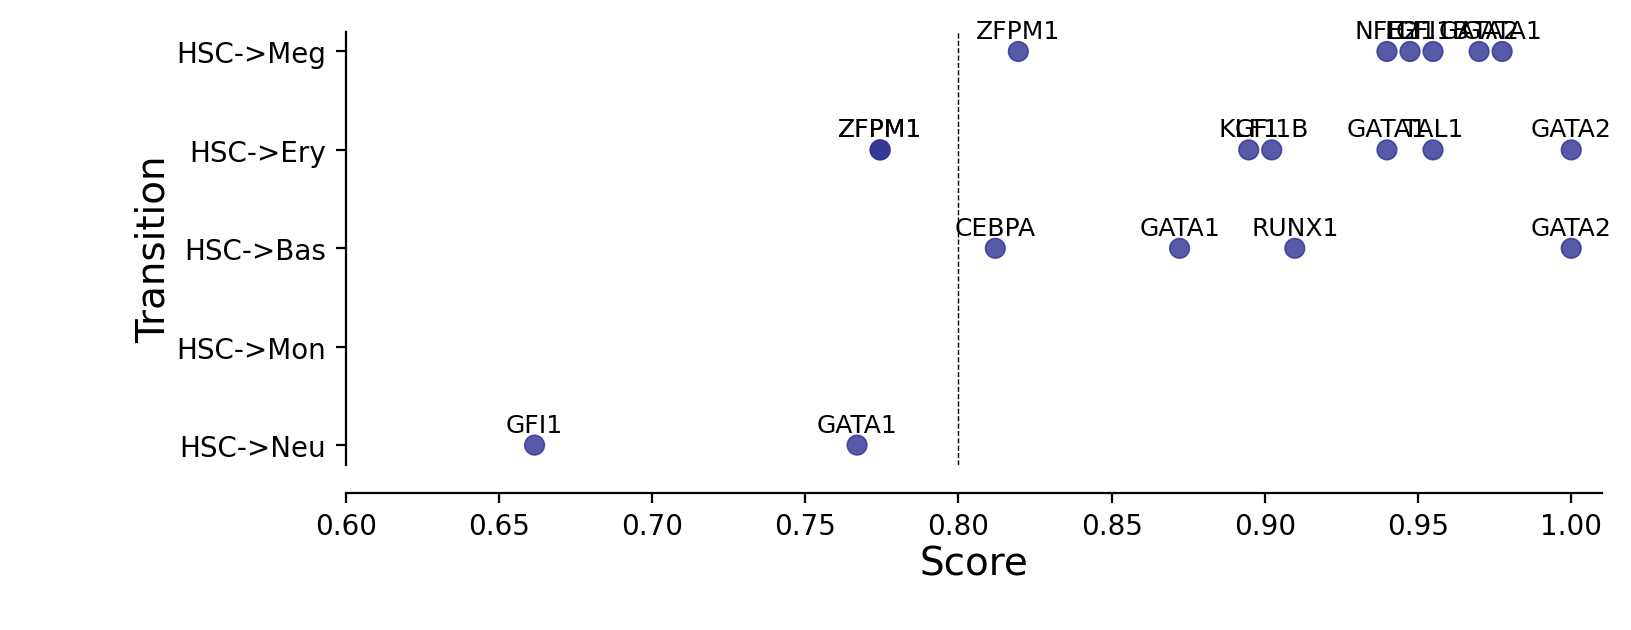

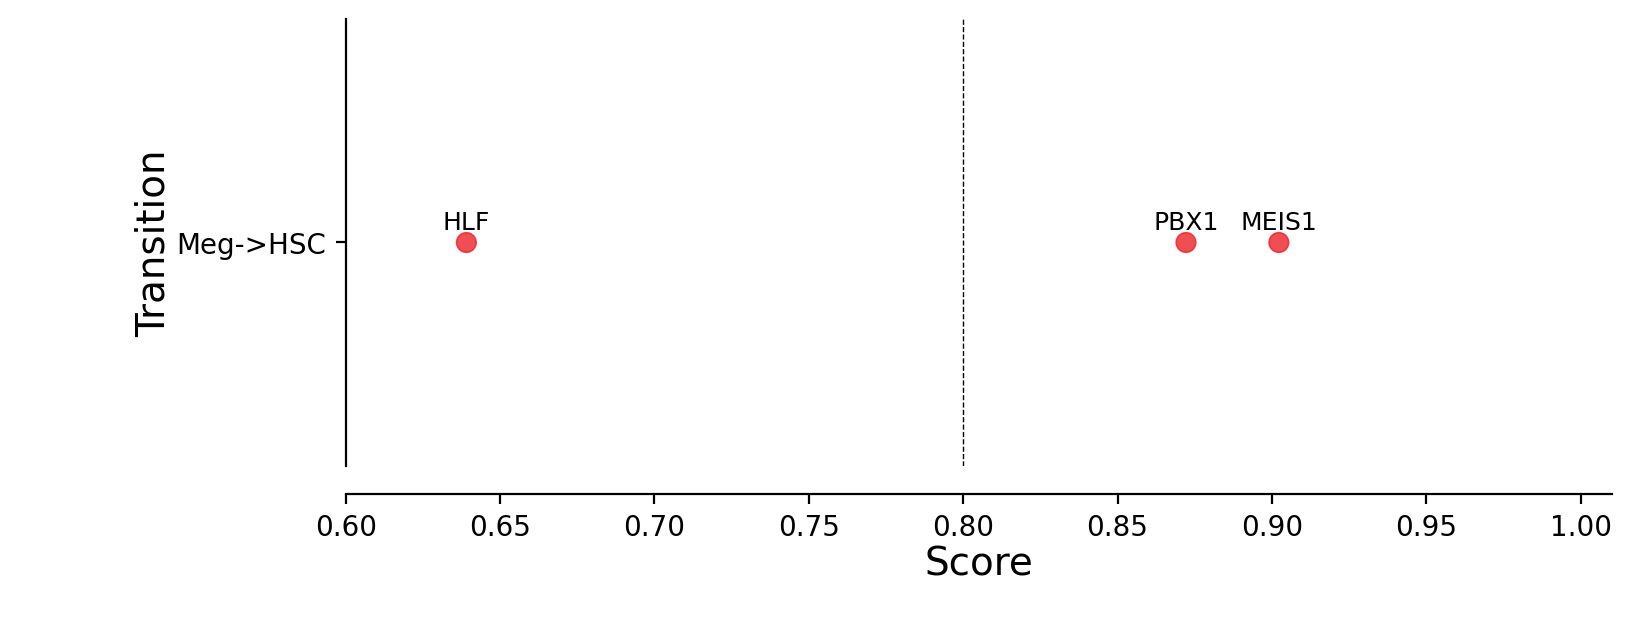

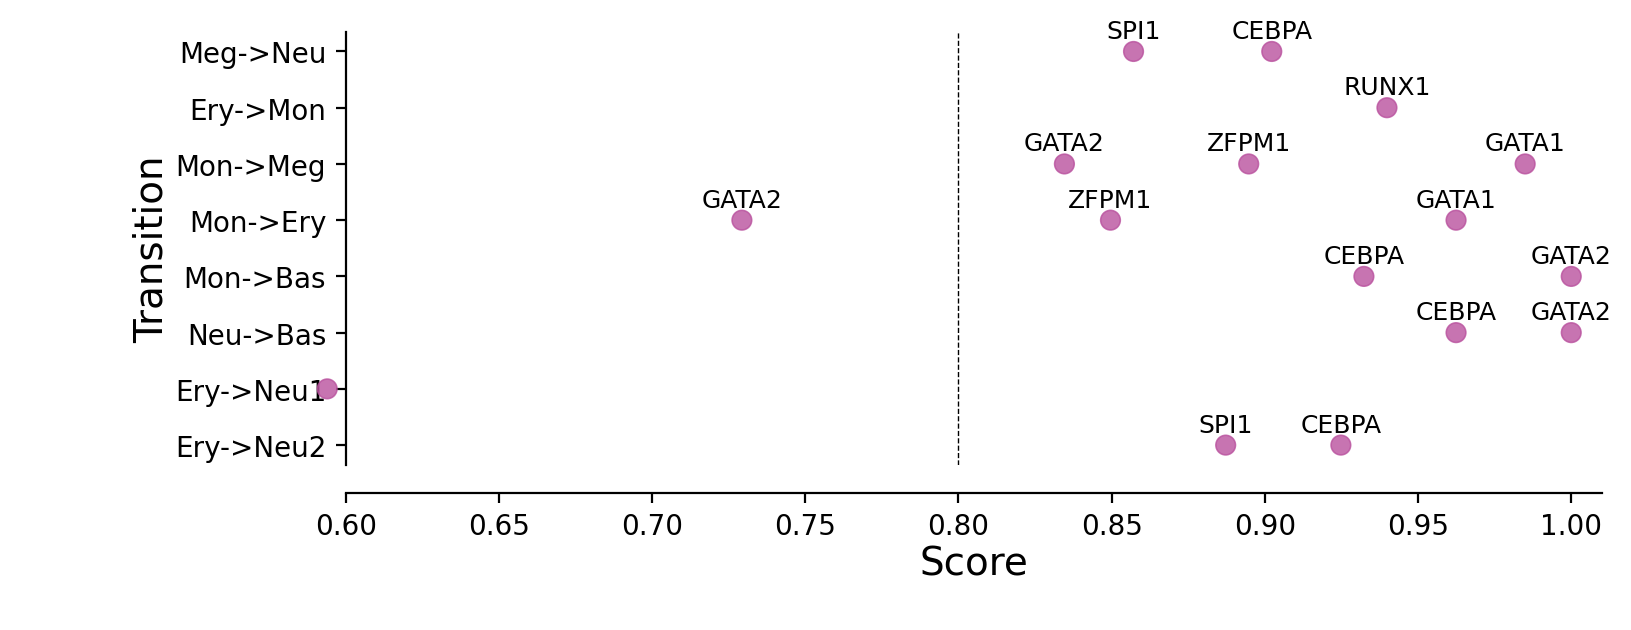

Reprogramming matrix shape: (42, 4)
Available transitions: ['HSC->Meg', 'HSC->Ery', 'HSC->Bas', 'HSC->Mon', 'HSC->Neu', 'Meg->HSC', 'Meg->Neu', 'Ery->Mon', 'Mon->Meg', 'Mon->Ery', 'Mon->Bas', 'Neu->Bas', 'Ery->Neu1', 'Ery->Neu2']


In [22]:
# Step 3: Plot with custom colors
for trans_type in ["development", "reprogramming", "transdifferentiation"]:
    dyn.pd.plot_transition_tf_analysis(
        reprogramming_df, 
        trans_type, 
        transition_color_dict=CUSTOM_COLORS,
        figsize=(8,3)
    )

# Access results
print("Reprogramming matrix shape:", reprogramming_df.shape)
print("Available transitions:", list(reprogramming_dict.keys()))

## ROC curve analyses of TF priorization of the LAP predictions
Last but not least, let us evaluate our TF ranking via receiver operating curve (ROC) analyses. ROC of LAP TF prioritization predictions when using all known genes of all known transitions as the gold standard (see STAR Methods of :cite:p:`QIU2022`) reveals an AUC (area under curve) of ``0.83``, again indicating our LAP predictions and TFs prioritization works quiet well. 

These analyses reveal the potential of the LAP approach to predict the optimal paths and TF cocktails of cell-fate transitions with high accuracy, paving the road for à la carte reprogramming between any cell types of interest for applications in regenerative medicine (Graf and Enver, 2009).

=== Running ROC Analysis on Processed Rankings ===
=== TF ROC Performance Analysis ===
Consolidating processed rankings...
Consolidating 13 transitions: ['HSC->Meg', 'HSC->Ery', 'HSC->Bas', 'HSC->Mon', 'HSC->Neu', 'Meg->HSC', 'Ery->Mon', 'Ery->Neu', 'Mon->Bas', 'Neu->Bas', 'Mon->Meg', 'Mon->Ery', 'Meg->Neu']
Calculating priority scores...
Calculating priority scores with reference_size=133 for 13 sources
Calculating ROC metrics...
Plotting ROC curve...


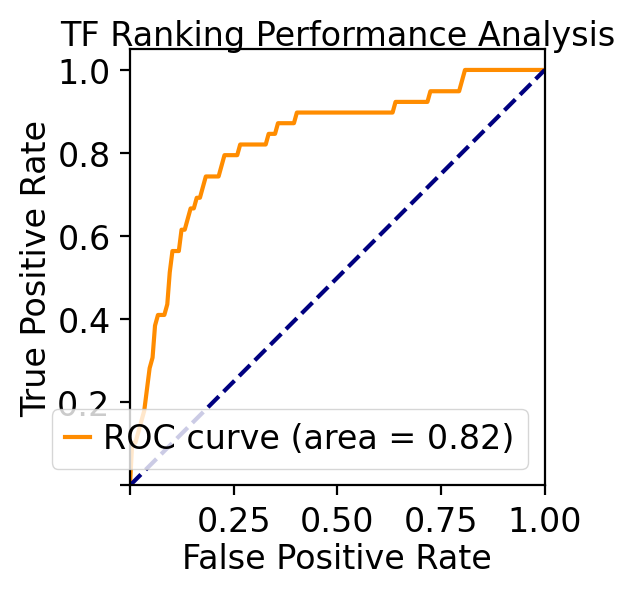


Performance Analysis Summary:
- ROC AUC: 0.824
- Total predictions: 1729
- Known TFs: 39
- Unknown TFs: 1690
- Mean priority score (known TFs): 0.820
- Mean priority score (unknown TFs): 0.496
- Transitions analyzed: ['HSC->Meg', 'HSC->Ery', 'HSC->Bas', 'HSC->Mon', 'HSC->Neu', 'Meg->HSC', 'Ery->Mon', 'Ery->Neu', 'Mon->Bas', 'Neu->Bas', 'Mon->Meg', 'Mon->Ery', 'Meg->Neu']


In [24]:
# === Method 1: Complete ROC Analysis (Recommended) ===
print("=== Running ROC Analysis on Processed Rankings ===")

# Analyze ROC performance using all available transitions
roc_results = dyn.pd.analyze_tf_roc_performance(
    processed_rankings=processed_rankings,
    plot_roc=True,
    roc_plot_params={
        'figsize': (3, 3),
        'fontsize': 12,
        'title': 'TF Ranking Performance Analysis',
        'roc_color': 'darkorange',
        'diagonal_color': 'navy',
        'legend_size':12,
    }
    
)


=== Analyzing Specific Transitions ===
=== TF ROC Performance Analysis ===
Consolidating processed rankings...
Consolidating 5 transitions: ['HSC->Meg', 'HSC->Ery', 'HSC->Bas', 'HSC->Mon', 'HSC->Neu']
Calculating priority scores...
Calculating priority scores with reference_size=133 for 5 sources
Calculating ROC metrics...
Plotting ROC curve...


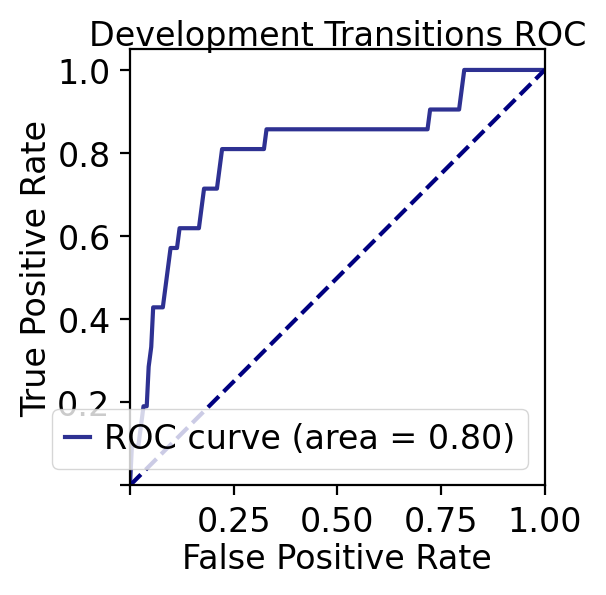


Performance Analysis Summary:
- ROC AUC: 0.805
- Total predictions: 665
- Known TFs: 21
- Unknown TFs: 644
- Mean priority score (known TFs): 0.799
- Mean priority score (unknown TFs): 0.494
- Transitions analyzed: ['HSC->Meg', 'HSC->Ery', 'HSC->Bas', 'HSC->Mon', 'HSC->Neu']


In [26]:

# === Method 2: Analyze Specific Transitions Only ===
print("\n=== Analyzing Specific Transitions ===")

# Analyze only development transitions
development_transitions = ["HSC->Meg", "HSC->Ery", "HSC->Bas", "HSC->Mon", "HSC->Neu"]
roc_results_dev = dyn.pd.analyze_tf_roc_performance(
    processed_rankings=processed_rankings,
    transitions_to_include=development_transitions,
    plot_roc=True,
    roc_plot_params={
        'figsize': (3, 3),
        'fontsize': 12,
        'title': 'Development Transitions ROC',
        'roc_color': '#2E3192',  # Development color
        'legend_size':12,
    }
)


In [28]:

# === Method 3: Get TF Statistics ===
print("\n=== TF Statistics ===")
tf_stats = dyn.pd.get_tf_statistics(processed_rankings, reprogramming_df)
print(f"Total unique TFs in rankings: {tf_stats['n_all_tfs']}")
print(f"Valid TFs in reprogramming analysis: {tf_stats['n_valid_tfs']}")
print(f"Overlap: {tf_stats['n_overlap']} ({tf_stats['overlap_percentage']:.1f}%)")




=== TF Statistics ===
Total unique TFs in rankings: 133
Valid TFs in reprogramming analysis: 17
Overlap: 17 (12.8%)



=== Custom ROC Analysis ===
Consolidating 13 transitions: ['HSC->Meg', 'HSC->Ery', 'HSC->Bas', 'HSC->Mon', 'HSC->Neu', 'Meg->HSC', 'Ery->Mon', 'Ery->Neu', 'Mon->Bas', 'Neu->Bas', 'Mon->Meg', 'Mon->Ery', 'Meg->Neu']
Calculating priority scores with reference_size=133 for 13 sources


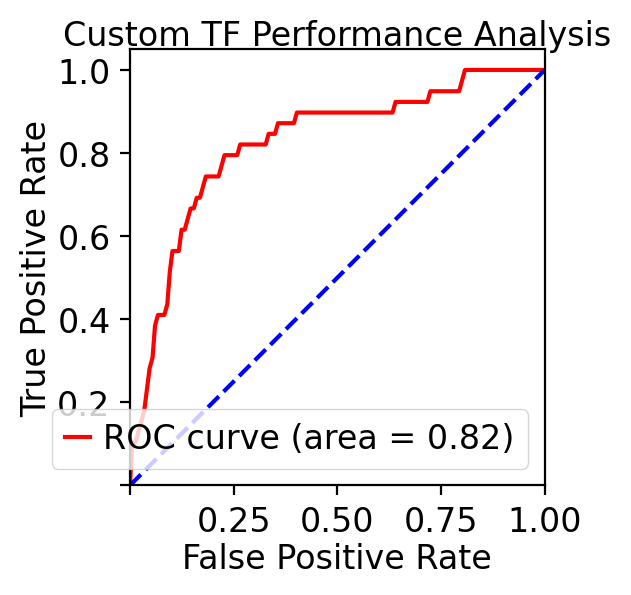

Custom analysis ROC AUC: 0.824


In [30]:
# === Method 4: Custom ROC Plot ===
print("\n=== Custom ROC Analysis ===")

# Get consolidated data for custom analysis
consolidated_df = dyn.pd.consolidate_processed_rankings(processed_rankings)
df_with_scores = dyn.pd.calculate_priority_scores_from_consolidated(consolidated_df)

# Custom ROC plot
if 'known_TF' in df_with_scores.columns:
    fpr, tpr, auc_score = dyn.pd.plot_roc_curve(
        y_true=df_with_scores["known_TF"].astype(int),
        y_scores=df_with_scores["priority_score"],
        figsize=(3, 3),
        fontsize=12,
        roc_color="red",
        diagonal_color="blue",
        title="Custom TF Performance Analysis",
        legend_size=12
    )
    print(f"Custom analysis ROC AUC: {auc_score:.3f}")